In [1]:
import requests
import pandas as pd
import numpy as np
import json
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from bs4 import BeautifulSoup
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import DistanceMetric
import matplotlib.pyplot as plt

# Raw Data

In [2]:
raw_data = pd.read_pickle('raw_data.pkl')
raw_data

,URL,Name,Scraped_Sidebar,content
0,https://en.wikipedia.org/wiki/2_Chainz,2 Chainz,{'Born': 'Tauheed K. Epps ( 1977-09-12 ) Septe...,"Tauheed K. Epps ( 1977-09-12 ) September 12, 1..."
1,https://en.wikipedia.org/wiki/21_Savage,21 Savage,"{'Birth name': 'Shéyaa Bin Abraham-Joseph', 'B...",Shéyaa Bin Abraham-Joseph ( 1992-10-22 ) Octob...
2,https://en.wikipedia.org/wiki/24kGoldn,24kGoldn,"{'Birth name': 'Golden Landis Von Jones', 'Als...",Golden Landis Von Jones Goldn El Dorado ( 2000...
3,https://en.wikipedia.org/wiki/3OH!3,3OH!3,"{'Origin': 'Boulder, Colorado , U.S.', 'Genres...","Boulder, Colorado , U.S. Electropop synth-pop ..."
4,https://en.wikipedia.org/wiki/5_Seconds_Of_Summer,5 Seconds Of Summer,"{'Also known as': '5SOS', 'Origin': 'Sydney , ...","5SOS Sydney , New South Wales , Australia Pop ..."
...,...,...,...,...
500,https://en.wikipedia.org/wiki/Blackbear,blackbear,"{'Origin': 'Canada', 'Genres': 'Northern conte...",Canada Northern contemporary 2000–present Trib...
501,https://en.wikipedia.org/wiki/Fun.,fun.,"{'Origin': 'New York City, U.S.', 'Genres': 'B...","New York City, U.S. Baroque pop [1] alternativ..."
502,https://en.wikipedia.org/wiki/Gnash,gnash,"{'Birth name': 'Garrett Charles Nash', 'Born':...","Garrett Charles Nash ( 1993-06-16 ) June 16, 1..."
503,https://en.wikipedia.org/wiki/Twenty_one_pilots,twenty one pilots,"{'Origin': 'Columbus, Ohio , U.S.', 'Genres': ...","Columbus, Ohio , U.S. Alternative rock alterna..."


# Labelling

In [3]:
mentors = [
'Adele',
'Alicia Keys',
'Amy Winehouse',
'Anderson .Paak',
'Bruno Mars',
'Jason Mraz',
'Josh Groban',
'Lady Gaga',
'Lana Del Rey',
'Lorde',
'Michael Buble',
'Natasha Bedingfield',
'Norah Jones',
'Pentatonix',
'Sam Smith',
'Sara Bareilles',
'Susan Boyle',
'Trans-Siberian Orchestra',
'Troye Sivan',
]


In [4]:
mentors_for_choosing = [
    'BTS',
    'Becky G',
    'Beyonce',
    'Billie Eilish',
    'Carly Rae Jepsen',
    'Celine Dion',
    'Charlie Puth',
    'Christina Aguilera',
    'Colbie Caillat',
    'Coldplay',
    'EXO',
    'Ed Sheeran',
    'Ellie Goulding',
    'Elton John',
    'Florence + The Machine',
    'GAYLE',
    'H.E.R.',
    'Hozier',
    'Joji',
    'Ariana Grande',
    'Capital Cities',
    'Kendrick Lamar',
    'Lauv',
    'Mac Miller',
    'Sade',
    'Steve Lacy',
]
np.random.seed(42)
choices = [np.random.choice([0,1]) for _ in mentors_for_choosing]
mentors_df = pd.DataFrame(zip(mentors_for_choosing, choices),
                       columns=['Artist', 'Label'])
mentors.extend(mentors_df[mentors_df['Label']==1]['Artist'].to_list())

In [5]:
mentors.sort()
mentors

['Adele',
 'Alicia Keys',
 'Amy Winehouse',
 'Anderson .Paak',
 'Becky G',
 'Bruno Mars',
 'Capital Cities',
 'Celine Dion',
 'Coldplay',
 'Florence + The Machine',
 'H.E.R.',
 'Hozier',
 'Jason Mraz',
 'Joji',
 'Josh Groban',
 'Lady Gaga',
 'Lana Del Rey',
 'Lauv',
 'Lorde',
 'Mac Miller',
 'Michael Buble',
 'Natasha Bedingfield',
 'Norah Jones',
 'Pentatonix',
 'Sade',
 'Sam Smith',
 'Sara Bareilles',
 'Steve Lacy',
 'Susan Boyle',
 'Trans-Siberian Orchestra',
 'Troye Sivan']

In [6]:
len(mentors)

31

In [7]:
correct_index = raw_data[raw_data['Name'].isin(mentors)].index.to_list()
label_arr = np.zeros(len(raw_data))
for i in correct_index:
    label_arr[i] = 1

In [8]:
raw_data['mentor'] = label_arr
raw_data.to_pickle('raw_with_labels.pkl')

# Query

In [9]:
query_df = pd.read_pickle('query_df.pkl')
query_df

,URL,Scraped_Sidebar,Sidebar_Content
Laufey,https://en.wikipedia.org/wiki/Laufey_(singer),{'Birth name': 'Laufey Lín Bīng Jónsdóttir / 林...,Laufey Lín Bīng Jónsdóttir / 林冰 [1] ( 1999-04-...


# Information Retrieval

In [12]:
def remove_parentheses(text):
    """Remove content within parenthesis from given text"""
    if isinstance(text, str):
        return re.sub(r'\(.*?\)', '', text)
    return text

raw_data['content'] = raw_data['content'].apply(remove_parentheses)
query_df['Sidebar_Content'] = (query_df['Sidebar_Content']
                               .apply(remove_parentheses))

In [15]:
vectorizer = TfidfVectorizer()
bow_matrix = vectorizer.fit_transform(raw_data['content'])
bow_matrix = pd.DataFrame(bow_matrix.toarray(), 
                          columns=vectorizer.get_feature_names_out())
bow_matrix.to_pickle('bow.pkl')

In [16]:
new_doc_vector = vectorizer.transform(query_df['Sidebar_Content'])
target_matrix = pd.DataFrame(new_doc_vector.toarray(),
                             columns=vectorizer.get_feature_names_out())
target_matrix.to_pickle('target.pkl')

# Result and Analysis

In [17]:
def dcos(vec1, vec2):
    """Compute cosine distance between vec1 and vec2

    If `vec1` and `vec2` are same-sized matrices, an ndarray of the cosine
    distance of corresponding rows will be returned instead.

    Parameters
    ----------
    vec1 : ndarray
        First vector
    vec2 : ndarray
        Second vector

    Returns
    -------
    float
        cosine distance of `vec1` and `vec2`
    """
    return 1 - cosine_similarity(vec1, vec2)

def get_confusion(actual, results, all_labels):
    """Accept the label of the correct class, the returned results as indices
    to the objects and all labels, and return the confusion matrix as a
    pandas DataFrame."""
    conf = {
        'relevant': {
            'relevant': 0,
            'irrelevant': 0
        },
        'irrelevant': {
            'relevant': 0,
            'irrelevant': 0
        },
    }

    for i, j in enumerate(all_labels):
        if i in results:
            if j == actual:
                conf['relevant']['relevant'] += 1
            else:
                conf['irrelevant']['relevant'] += 1
        else:
            if j == actual:
                conf['relevant']['irrelevant'] += 1
            else:
                conf['irrelevant']['irrelevant'] += 1

    return pd.DataFrame(conf)

def nearest_k(query, objects, k, dist):
    """Return the indices to objects most similar to query

    Parameters
    ----------
    query : ndarray
        query object represented in the same form vector representation as the
        objects
    objects : ndarray
        vector-represented objects in the database; rows correspond to
        objects, columns correspond to features
    k : int
        number of most similar objects to return
    dist : function
        accepts two ndarrays as parameters then returns their distance

    Returns
    -------
    most_similar : ndarray
        Indices to the most similar objects in the database
    """
    return np.argsort(dist(query, objects).flatten(), kind="stable")[:k]

def precision(confusion):
    """Return precision from given confusion matrix"""
    return confusion.iat[0,0]/confusion.iloc[0,:].sum()

def recall(confusion):
    """Return recall from given confusion matrix"""
    return confusion.iat[0,0]/confusion.iloc[:,0].sum()

def f_measure(precision, recall, beta=1):
    """Return F-measure from given precision, recall, and beta"""
    return ((1 + beta**2) * (precision * recall)
            / ((beta**2 * precision) + recall))

def pr_curve(query, objects, dist, actual, all_labels):
    """Draw PR curve

    Parameters
    ----------
    query: array-like
        find objects similar to this query
    objects: ndarray
        database of objects to search in
    dist: function
        function that returns the distance of two input `ndarray`s
    actual: int
        class label
    all_labels: array-like
        label of each object in the database

    Returns
    -------
    matplotlib.Axes
        rendered PR curve
    """
    all_labels = np.asarray(all_labels)
    results = nearest_k(query, objects, len(all_labels), dist)
    rs = (all_labels[results] == actual).cumsum()
    N = (all_labels == actual).sum()
    precisions = rs / np.arange(1, len(rs) + 1)
    recalls = rs / N
    recalls = [0] + recalls.tolist()
    precisions = [1] + precisions.tolist()

    fig, ax = plt.subplots()
    ax.set_aspect("equal")
    ax.step(recalls, precisions, where="post")
    ax.fill_between(recalls, precisions, step="post", alpha=0.8)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("recall")
    ax.set_ylabel("precision")
    ax.set_title('Precision-Recall Curve')
    aucpr = auc_pr(query, objects, dist,
                    actual,all_labels)
    ax.text(0.3, 0.3, f"AUC-PR: {aucpr:.4f}",
            bbox=dict(alpha=0.5))
    txt="""
    The PR curve retains a high precision when k is low,
    and quickly dips afterwards. The curve shows that after
    getting the top 3 artists which were true positives,
    the next 28 mentors were spread out until k reaches the maximum."""
    plt.figtext(0, -0.2, txt, wrap=True, horizontalalignment='left',
                fontsize=12)
    return ax

def auc_pr(query, objects, dist, actual, all_labels):
    """Compute area under the PR curve

    Parameters
    ----------
    query: array-like
        find objects similar to this query
    objects: numpy.ndarray
        database of objects to search in
    dist: function
        function that returns the distance of two input `ndarray`s
    actual: int
        class label
    all_labels: array-like
        label of each object in the database

    Returns
    -------
    float
        area under the PR curve
    """
    from scipy.integrate import trapz

    all_labels = np.asarray(all_labels)
    results = nearest_k(query, objects, len(all_labels), dist)
    rs = (all_labels[results] == actual).cumsum()
    N = (all_labels == actual).sum()
    precisions = rs / np.arange(1, len(rs) + 1)
    recalls = rs / N
    recalls = [0] + recalls.tolist()
    precisions = [1] + precisions.tolist()
    return trapz(precisions, recalls)

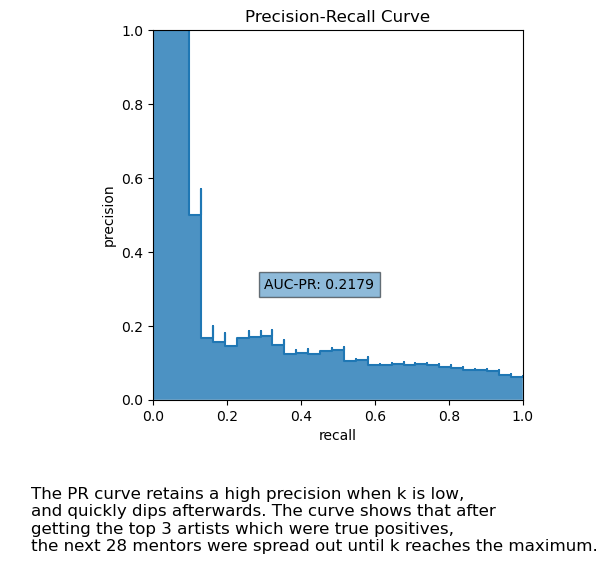

In [18]:
pr_curve(target_matrix, bow_matrix, dcos, 1, raw_data['mentor'].to_list());

In [19]:
auc_pr(target_matrix, bow_matrix, dcos, 1, raw_data['mentor'].to_list())

0.21793544807089688

# Results

In [20]:
result = (raw_data.iloc[nearest_k(target_matrix, bow_matrix, 5, dcos)]
         )[['Name', 'mentor']]
result

,Name,mentor
422,Steve Lacy,1.0
257,Lauv,1.0
341,Norah Jones,1.0
137,Em Beihold,0.0
369,Pop Smoke,0.0


In [21]:
result.to_pickle('result.pkl')

In [22]:
conf_mat = get_confusion(1, nearest_k(target_matrix, bow_matrix, 5, dcos),
                         raw_data['mentor'])

In [23]:
precision(conf_mat)

0.6

In [24]:
recall(conf_mat)

0.0967741935483871

In [25]:
conf_mat

,relevant,irrelevant
relevant,3,2
irrelevant,28,472


In [26]:
f_measure(precision(conf_mat), recall(conf_mat), beta=0.3)

0.41976893453145064